In [14]:
import numpy as np
import pandas as pd 
import numpy.random as rnd
import matplotlib.pyplot as plt
import time 
import pandas as pd 

We will need to import the following classes 

In [15]:
from routines.cox_rs_routines import gauss_model, rs_cox

In order to solve the RS equations, we first need to define the data-generating process.
Here we assume that each component of $\bm{\beta}_0$ is sampled from a Gauss Bernoulli distribution, i.e 
$$
    \mathbf{e}_{k}'\beta_0 \sim \mathcal{P}_{\beta_0}, \quad \mathcal{P}_{\beta_0}(x) = (1-\nu)\delta(x) + \nu \phi(x, \sigma_0),
$$
where
$$
    \phi(x, \sigma_0) = \frac{1}{\sqrt{2\pi}\sigma_0}{\rm e}^{-\frac{1}{2}(x/\sigma_0)^2},
$$
with $\sigma_0$ fixed to have that 
$$
    \|\bm{\beta}_0\|_2^2 = \int x^2 \mathcal{P}_{\beta_0}(x) {\rm d} x = \nu \sigma_0^2 = \theta_0^2 \ ,
$$
i.e. $\sigma_0 = \theta_0 / \sqrt{\nu}$.

In [16]:
#number of covariates
p = 2000
#overfitting ratio
zeta = 2.0
#number of covariates
n = int(p / zeta)
#sparsity
delta = 0.01
#signal strength 
theta0 = 1.0
#define the true parameters of the cumulative hazard
phi0 = - np.log(2)
rho0 = 2.0
model = 'log-logistic'
#define the interval in which the censoring is uniform
tau1 = 1.0
tau2 = 2.0
#equivalent gaussian generating process
gauss_process = gauss_model(theta0, phi0, rho0, tau1, tau2, model)

The istance 'gauss_process' of the class 'gauss_model' can be used to generate the data from either a 'log-logistic' or 'weibull' model:

1. 'log-logistic' $\Lambda_0(t) = \log (1.0 + {\rm e}^{\rho_0 \log t + \phi_0})$


2. 'weibull' $\Lambda_0(t) = {\rm e}^{\rho_0 \log t + \phi_0}$


where $\rho_0, \phi_0$ are the true model parameters that describe the cumulative hazard. 

At this point we can declare an instance of the rs_cox class, here 'cox_rs'. The method 'solve' can then be used to solve the rs equations at a fixed value of the paramters $\alpha$ and $\rho$ as follows.

In [17]:
pop_size = 10000
cox_rs = rs_cox(delta, zeta, gauss_process, pop_size)
cox_rs.alpha = 0.75
cox_rs.eta = 0.25
cox_rs.solve()
res = np.array([cox_rs.w, cox_rs.v, cox_rs.tau, cox_rs.hat_w, cox_rs.hat_v, cox_rs.hat_tau], float)
print(res)

[0.30636916 0.20111364 0.2322961  0.87311406 1.97004638 4.23694224]


To solve along a full regularization path we define the following function.

In [18]:
def run_rs(values, ratio, delta, zeta, gm, m, verbose = False):
    metrics = np.empty((len(values),7))
    cox_rs = rs_cox(delta, zeta, gm, m)
    # loop over the values of lambda
    for l in range(len(values)):
        cox_rs.alpha = values[l] * ratio
        cox_rs.eta = values[l] * (1-ratio)
        cox_rs.solve()
        res = np.array([values[l], cox_rs.w, cox_rs.v, cox_rs.tau, cox_rs.hat_w, cox_rs.hat_v, cox_rs.hat_tau], float)
        if verbose:
            print(res)
        metrics[l,:] = res
    df = pd.DataFrame(metrics, columns=['alphas', 'w', 'v', 'tau', 'hat_w', 'hat_v', 'hat_tau'])
    return df

And use it along the path specified below.

In [19]:
#alpha values  
values = np.exp(np.linspace(np.log(10.0), np.log(0.5), 100))
#l1_ratio
ratio = 0.75
#solve along the regularization path
rs_df = run_rs(values, ratio, delta, zeta, gauss_process, pop_size, verbose = True)

[1.00000000e+01 3.11265821e-05 5.39793774e-04 1.51005548e-06
 7.64573255e-01 1.92573292e+00 3.70920272e+00]
[9.70193326e+00 4.73469574e-05 6.90056065e-04 2.29695134e-06
 7.64576750e-01 1.92572748e+00 3.70920476e+00]
[9.41275090e+00 7.04735237e-05 8.72157263e-04 3.41887524e-06
 7.64581667e-01 1.92571944e+00 3.70920766e+00]
[9.13218811e+00 1.02772953e-04 1.09046081e-03 4.98577538e-06
 7.64588473e-01 1.92570795e+00 3.70921171e+00]
[8.85998796e+00 1.47015827e-04 1.34947163e-03 7.13203329e-06
 7.64597722e-01 1.92569192e+00 3.70921726e+00]
[8.59590118e+00 2.06521451e-04 1.65376462e-03 1.00186288e-05
 7.64610088e-01 1.92567006e+00 3.70922473e+00]
[8.33968596e+00 2.85191763e-04 2.00790502e-03 1.38347724e-05
 7.64626349e-01 1.92564083e+00 3.70923459e+00]
[8.09110766e+00 3.87532170e-04 2.41636400e-03 1.87988957e-05
 7.64647415e-01 1.92560248e+00 3.70924743e+00]
[7.84993866e+00 5.18657236e-04 2.88343085e-03 2.51589014e-05
 7.64674305e-01 1.92555300e+00 3.70926388e+00]
[7.61595810e+00 6.84280618e-

We can now plot the value of the RS order parameters along the regularization path.

(0.5, 3.0)

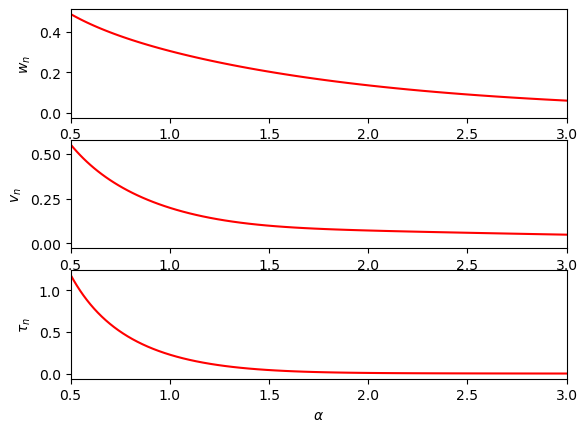

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(rs_df['alphas'],rs_df['w'],'r-')
ax1.set_ylabel(r'$w_n$')
ax1.set_xlim(left = min(rs_df['alphas']), right = 3.0)
# ax1.set_xlabel(r'$\alpha$')

ax2.plot(rs_df['alphas'],rs_df['v'],'r-')
ax2.set_ylabel(r'$v_n$')
ax2.set_xlim(left = min(rs_df['alphas']), right = 3.0)
# ax2.set_xlabel(r'$\alpha$')

ax3.plot(rs_df['alphas'],rs_df['tau'],'r-')
ax3.set_ylabel(r'$\tau_n$')
ax3.set_xlabel(r'$\alpha$')
ax3.set_xlim(left = min(rs_df['alphas']), right = 3.0)



(0.5, 3.0)

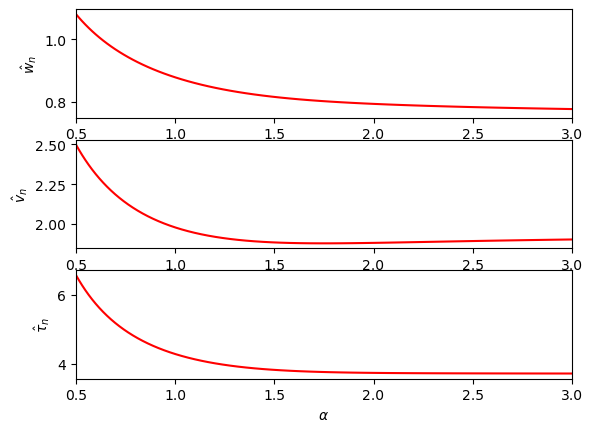

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(rs_df['alphas'],rs_df['hat_w'],'r-')
ax1.set_ylabel(r'$\hat{w}_n$')
ax1.set_xlim(left = min(rs_df['alphas']), right = 3.0)
# ax1.set_xlabel(r'$\alpha$')

ax2.plot(rs_df['alphas'],rs_df['hat_v'],'r-')
ax2.set_ylabel(r'$\hat{v}_n$')
ax2.set_xlim(left = min(rs_df['alphas']), right = 3.0)
# ax2.set_xlabel(r'$\alpha$')

ax3.plot(rs_df['alphas'],rs_df['hat_tau'],'r-')
ax3.set_ylabel(r'$\hat{\tau}_n$')
ax3.set_xlabel(r'$\alpha$')
ax3.set_xlim(left = min(rs_df['alphas']), right = 3.0)


For the sake of compliteness we also show how one can compare with the quantities computed from the data. To do this we need to generate synthetic data from the model that we specified above. 
So we import the class 'surv_models'. To fit a regularized Cox regression model we import the class 'cox_model'.

In [22]:
from routines.cox_routines import cox_model
from routines.surv_data_generator import surv_models

def isotropic_setting(p, nu, theta0):
    beta0 = rnd.normal(size = p)* np.array(rnd.random(size = p)<nu, int)
    beta0 = beta0 / np.sqrt(beta0 @ beta0)
    beta0 = theta0 * np.sqrt(p) * beta0
    #generate covariance matrix
    Sigma0 = np.diag(np.ones(p))/p
    return Sigma0, beta0

#define the population covariance matrix and the true beta

Sigma0, beta0 = isotropic_setting(p, delta, theta0)

In [23]:
#data generating process
data_gen_process = surv_models(Sigma0, beta0, phi0, rho0, tau1, tau2, model) 

Next we aim at :
1. generating a data-set via the method 'gen' of the class surv_models, 
2. fit a regularized cox model via the routine fit of the class cox_model.

This is done in the next function, where GM is an instance of surv_models and cox_m is an instance of cox_model. Notice that the method 'fit' does not know the data-generating model, i.e. it only uses the data ! The estimation method is performed as in the manuscript in reference, for more detail one can check the fyle cox_routine.py in the folder routines


In [24]:
def experiment(counter, GM, cox_m, method, n, verbose):
    tic = time.time()
    #generate data
    T, C, X = GM.gen(n)
    cox_m.fit(T, C, X, method, verb_flag = verbose)
    toc = time.time()
    print('experiment '+str(counter)+ ' time elapsed = '+str((toc-tic)/60))
    return cox_m.ws, cox_m.vs, cox_m.taus, cox_m.hat_ws, cox_m.hat_vs, cox_m.hat_taus

Since we need to repeat the experiment above a number of times and record its output, it is handy to define the following 

In [25]:
def run_sim(p, n, values, ratio, GM, method, m, verbose = False):

    cox_m = cox_model(values, ratio)

    w = np.zeros((m, len(values)))
    v= np.zeros((m, len(values)))
    tau = np.zeros((m, len(values)))
    hat_w = np.zeros((m, len(values)))
    hat_v = np.zeros((m, len(values)))
    hat_tau = np.zeros((m, len(values)))

    big_tic = time.time()
    for i in range(m):
        w[i,:], v[i,:], tau[i,:], hat_w[i,:], hat_v[i,:], hat_tau[i,:] = experiment(i, GM, cox_m, method, n, verbose)
    big_toc = time.time()
    print('total elapsed time = ' + str((big_toc-big_tic)/60))

    data = {
        'alphas' : values,
        'w_mean' : np.mean(w, axis = 0),
        'w_std' : np.std(w, axis = 0),
        'v_mean' : np.mean(v, axis = 0),
        'v_std' : np.std(v, axis = 0),
        'tau_mean' : np.mean(tau, axis = 0),
        'tau_std' : np.std(tau, axis = 0),
        'hat_w_mean' : np.mean(hat_w, axis = 0),
        'hat_w_std' : np.std(hat_w, axis = 0),
        'hat_v_mean' : np.mean(hat_v, axis = 0),
        'hat_v_std' : np.std(hat_v, axis = 0),
        'hat_tau_mean' : np.mean(hat_tau, axis = 0),
        'hat_tau_std' : np.std(hat_tau, axis = 0)
    }
    df = pd.DataFrame(data)
    return df 

To limit the running time, we here display averages over 5 realizations.
First with the 'COX-AMP' method and then with the 'COX-CD' method.

In [26]:
# #simulate the data and perform regressions with COX - AMP
m = 5 #number of repetitions to compute average
sim_df = run_sim(p, n, values, ratio, data_gen_process, 'amp', m)


experiment 0 time elapsed = 0.7389440933863322
experiment 1 time elapsed = 0.8727427045504252
experiment 2 time elapsed = 0.7693431337674459
experiment 3 time elapsed = 0.795281998316447
experiment 4 time elapsed = 0.7355828960736592
total elapsed time = 3.9119030674298605


(0.5, 3.0)

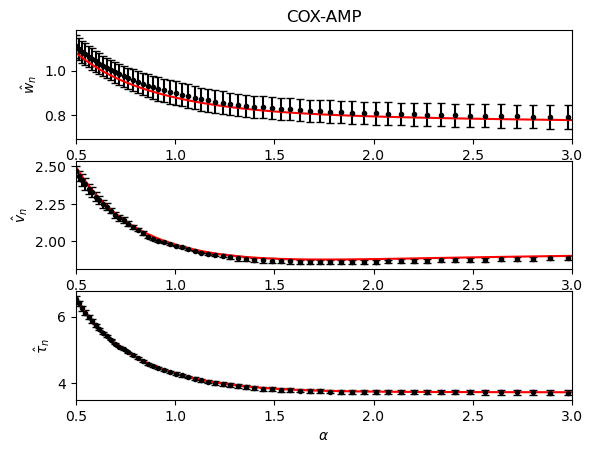

In [27]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(311)
ax2 = fig1.add_subplot(312)
ax3 = fig1.add_subplot(313)
ax1.set_title('COX-AMP')
ax1.errorbar(sim_df['alphas'],sim_df['hat_w_mean'],yerr =sim_df['hat_w_std'],fmt = 'k.', capsize = 3)
ax1.plot(rs_df['alphas'],rs_df['hat_w'],'r-')
ax1.set_ylabel(r'$\hat{w}_n$')
ax1.set_xlim(left = min(rs_df['alphas']), right = 3.0)
# ax1.set_xlabel(r'$\alpha$')

ax2.errorbar(sim_df['alphas'],sim_df['hat_v_mean'],yerr =sim_df['hat_v_std'],fmt = 'k.', capsize = 3)
ax2.plot(rs_df['alphas'],rs_df['hat_v'],'r-')
ax2.set_ylabel(r'$\hat{v}_n$')
ax2.set_xlim(left = min(rs_df['alphas']), right = 3.0)
# ax2.set_xlabel(r'$\alpha$')

ax3.errorbar(sim_df['alphas'],sim_df['hat_tau_mean'],yerr =sim_df['hat_tau_std'],fmt = 'k.', capsize = 3)
ax3.plot(rs_df['alphas'],rs_df['hat_tau'],'r-')
ax3.set_ylabel(r'$\hat{\tau}_n$')
ax3.set_xlabel(r'$\alpha$')
ax3.set_xlim(left = min(rs_df['alphas']), right = 3.0)

(0.5, 3.0)

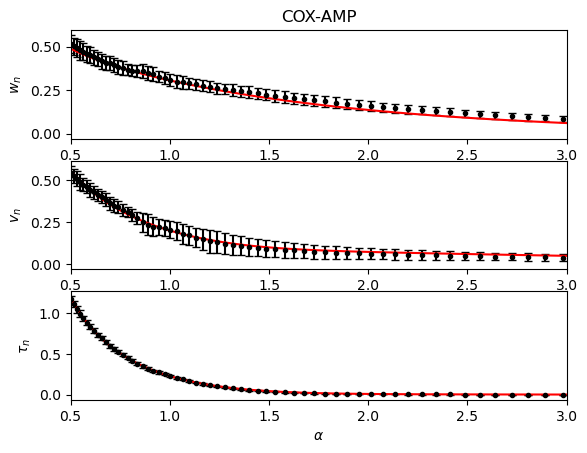

In [28]:

fig2 = plt.figure()
ax1 = fig2.add_subplot(311)
ax2 = fig2.add_subplot(312)
ax3 = fig2.add_subplot(313)

ax1.set_title('COX-AMP')
ax1.errorbar(sim_df['alphas'],sim_df['w_mean'],yerr =sim_df['w_std'],fmt = 'k.', capsize = 3)
ax1.plot(rs_df['alphas'],rs_df['w'],'r-')
ax1.set_ylabel(r'$w_n$')
ax1.set_xlim(left = min(rs_df['alphas']), right = 3.0)
# ax1.set_xlabel(r'$\alpha$')

ax2.errorbar(sim_df['alphas'],sim_df['v_mean'],yerr =sim_df['v_std'],fmt = 'k.', capsize = 3)
ax2.plot(rs_df['alphas'],rs_df['v'],'r-')
ax2.set_ylabel(r'$v_n$')
ax2.set_xlim(left = min(rs_df['alphas']), right = 3.0)
# ax2.set_xlabel(r'$\alpha$')

ax3.errorbar(sim_df['alphas'],sim_df['tau_mean'],yerr =sim_df['tau_std'],fmt = 'k.', capsize = 3)
ax3.plot(rs_df['alphas'],rs_df['tau'],'r-')
ax3.set_ylabel(r'$\tau_n$')
ax3.set_xlabel(r'$\alpha$')
ax3.set_xlim(left = min(rs_df['alphas']), right = 3.0)

In [29]:
# #simulate the data and perform regressions with COX - CD
m = 5 #number of repetitions to compute average
sim_df = run_sim(p, n, values, ratio, data_gen_process, 'cd', m)

experiment 0 time elapsed = 0.36185628970464073
experiment 1 time elapsed = 0.3934470931688944
experiment 2 time elapsed = 0.46446603536605835
experiment 3 time elapsed = 0.45316282908121747
experiment 4 time elapsed = 0.4746258775393168
total elapsed time = 2.1475759983062743


(0.5, 3.0)

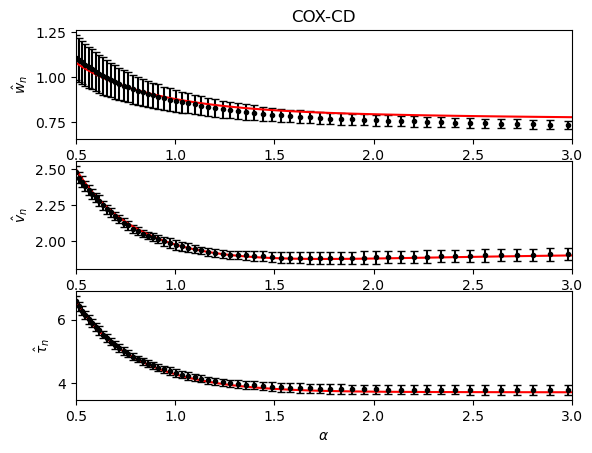

In [30]:
fig1 = plt.figure()

ax1 = fig1.add_subplot(311)
ax2 = fig1.add_subplot(312)
ax3 = fig1.add_subplot(313)
ax1.set_title('COX-CD')
ax1.errorbar(sim_df['alphas'],sim_df['hat_w_mean'],yerr =sim_df['hat_w_std'],fmt = 'k.', capsize = 3)
ax1.plot(rs_df['alphas'],rs_df['hat_w'],'r-')
ax1.set_ylabel(r'$\hat{w}_n$')
ax1.set_xlim(left = min(rs_df['alphas']), right = 3.0)
# ax1.set_xlabel(r'$\alpha$')

ax2.errorbar(sim_df['alphas'],sim_df['hat_v_mean'],yerr =sim_df['hat_v_std'],fmt = 'k.', capsize = 3)
ax2.plot(rs_df['alphas'],rs_df['hat_v'],'r-')
ax2.set_ylabel(r'$\hat{v}_n$')
ax2.set_xlim(left = min(rs_df['alphas']), right = 3.0)
# ax2.set_xlabel(r'$\alpha$')

ax3.errorbar(sim_df['alphas'],sim_df['hat_tau_mean'],yerr =sim_df['hat_tau_std'],fmt = 'k.', capsize = 3)
ax3.plot(rs_df['alphas'],rs_df['hat_tau'],'r-')
ax3.set_ylabel(r'$\hat{\tau}_n$')
ax3.set_xlabel(r'$\alpha$')
ax3.set_xlim(left = min(rs_df['alphas']), right = 3.0)

(0.5, 3.0)

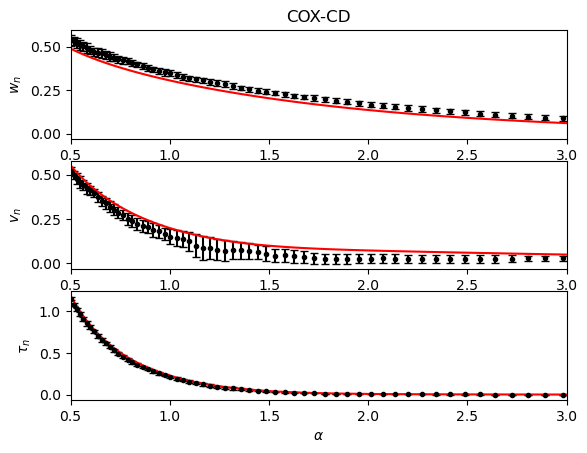

In [31]:
fig2 = plt.figure()
ax1 = fig2.add_subplot(311)
ax2 = fig2.add_subplot(312)
ax3 = fig2.add_subplot(313)

ax1.set_title('COX-CD')
ax1.errorbar(sim_df['alphas'],sim_df['w_mean'],yerr =sim_df['w_std'],fmt = 'k.', capsize = 3)
ax1.plot(rs_df['alphas'],rs_df['w'],'r-')
ax1.set_ylabel(r'$w_n$')
ax1.set_xlim(left = min(rs_df['alphas']), right = 3.0)
# ax1.set_xlabel(r'$\alpha$')

ax2.errorbar(sim_df['alphas'],sim_df['v_mean'],yerr =sim_df['v_std'],fmt = 'k.', capsize = 3)
ax2.plot(rs_df['alphas'],rs_df['v'],'r-')
ax2.set_ylabel(r'$v_n$')
ax2.set_xlim(left = min(rs_df['alphas']), right = 3.0)
# ax2.set_xlabel(r'$\alpha$')

ax3.errorbar(sim_df['alphas'],sim_df['tau_mean'],yerr =sim_df['tau_std'],fmt = 'k.', capsize = 3)
ax3.plot(rs_df['alphas'],rs_df['tau'],'r-')
ax3.set_ylabel(r'$\tau_n$')
ax3.set_xlabel(r'$\alpha$')
ax3.set_xlim(left = min(rs_df['alphas']), right = 3.0)